In [15]:
import numpy as np
import matplotlib.pyplot as plt
import json
import math
from keras.datasets import mnist
import time

np.random.seed(10605)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
def read_and_process_data(file_path_train, file_path_val, combine_client_data=False):
    '''
    parses data in given train and test data directories
    assumes:
    - the data in the input directories are .json files with 
        keys 'users' and 'user_data'
    - the set of train set users is the same as the set of test set users
    
    combine_client_data : flag to indicate whether all client data should be 
                          stacked together. Should be true when running sgd
                          and false when running fedavg

                          note that since each client dataset can be generated
                          with different underlying distributions, we shouldn't
                          combine and reallocate the data for fedavg; instead 
                          the data should remain split
    Return:
        trainX
        trainY
        valX
        valY
    '''
    clients = []
    train_data = {}
    test_data = {}

    with open(file_path_train, 'r') as inf:
        cdata = json.load(inf)
    clients.extend(cdata['users'])
    train_data.update(cdata['user_data'])

    with open(file_path_val, 'r') as inf:
        cdata = json.load(inf)
    test_data.update(cdata['user_data'])

    clients = list(sorted(train_data.keys()))

    trainX = []
    trainY = []
    valX = []
    valY = []
    for client in clients:
        x = np.array(train_data[client]['x'])
        y = np.array(train_data[client]['y']).astype(int)
        trainX.append(x)
        trainY.append(y)

        x = np.array(test_data[client]['x'])
        y = np.array(test_data[client]['y']).astype(int)
        valX.append(x)
        valY.append(y)

    # we want to normalize the input data
    def normalize(data):
        data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-9)
        np.clip(data, 0,1)
        return data

    # we want to convert the labels into one hot vectors
    def convert_to_one_hot(data):
        one_hot = np.zeros((data.size, 10))
        one_hot[np.arange(len(one_hot)), data] = 1
        return one_hot

    trainX = [normalize(x) for x in trainX]
    valX = [normalize(x) for x in valX]
    trainY = [convert_to_one_hot(y) for y in trainY]
    valY = [convert_to_one_hot(y) for y in valY]

    if combine_client_data:
        trainX = np.vstack(trainX)
        trainY = np.vstack(trainY)
    
    valX = np.vstack(valX)
    valY = np.vstack(valY)

    return (trainX, trainY), (valX, valY)


In [17]:
class DataLoader():
    '''
    Given a dataset, the dataloader enables you to easily return
    batches of data
    '''

    def __init__(self, x, y, batch_size=1):
        self.x = x
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        '''
        return the length of the dataset
        since we're batching data, this should
        correspond to the number of batches
        '''

        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, i):
        '''
        return a tuple (data, labels) for batch i
        '''
        start = i*self.batch_size
        end = (i+1)*self.batch_size
        if end >= len(self.x):
            end = len(self.x)

        return self.x[start:end], self.y[start:end]

    def shuffle(self):
        '''
        Permute the order of the dataset
        '''
        p = np.random.permutation(len(self.x))
        self.x = self.x[p]
        self.y = self.y[p]

In [58]:
class Layer():
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        NotImplemented

    def backward(self, delta):
        NotImplemented

class Linear(Layer):
    def __init__(self, num_in, num_out):
        self.num_in = num_in
        self.num_out = num_out

        self.W = np.random.normal(-1, 1, (num_in, num_out))
        self.b = np.random.normal(-1, 1, (1,num_out))

        self.dW = np.zeros(())
        self.db = np.zeros(())

    def forward(self, x):
        '''
        Parameters
        ----------
        x : np.array (batch_size, num_in)

        Returns
        -------
        out : np.array (batch_size, num_out)
        '''

        # TODO: compute the forward pass through this layer
        # hint: do you need to store some information for use later?
        self.x    = x
        self.N    = x.shape[0] # batch size-->store it
        self.Ones = np.ones((self.N,1), dtype="f")
        out        = np.dot(x, self.W) + np.dot(self.Ones, self.b)

        return out

    def backward(self, delta):
        '''
        Compute and store dL/dW (self.dW) and dL/db (self.db) 
            (averaged across the batch)

        Compute and return dL/dx

        Parameters
        ----------
        delta : np.array (batch_size, num_out), this is equivalent to dL/dout

        Returns
        -------
        dx : np.array (batch_size, num_in)
        '''

        # TODO: compute the backward pass through this layer
        # you should save the values of self.dW and self.db for use later
        # you should return dL/dx
        # rewrite delat = dL/dout = dLdZ
        dZdx      =  self.W
        dZdW      =  self.x
        dZdi      = None
        dZdb      = self.Ones
        dLdx      = np.dot(delta, np.transpose(dZdx))
        dLdW      = np.dot(np.transpose(delta), dZdW).T
        dLdi      = None
        dLdb      = np.dot(np.transpose(delta), dZdb).T
        self.dW = dLdW / self.N # (averaged across the batch)
        self.db = dLdb / self.N # (averaged across the batch)

        return dLdx

    def step(self, lr):
        '''
        Gradient descent update step

        Parameters
        ----------
        lr : float, the learning rate
        '''
        self.W -= lr * self.dW
        self.b -= lr * self.db

    def add_weights(self, other, scalar=1):
        """
        Add the weights of the other Linear layer to this one

        Parameters
        ----------
        other : Linear, you can directly access weights from other using
                other.W and other.b
            
        scalar : float, scalar value to multiply by other's weights when 
                 adding to these weights
        """

        # TODO: add scalar*other.W to self.W
        # TODO: add scalar*other.b to self.W
        # note: remember to use np.copy to ensure you make a deep copy 
        #       of other's weights
        self.W +=  scalar*np.copy(other.W)
        self.b += scalar*np.copy(other.b)

        

    def zero_weights(self):
        '''
        Set the weights and bias to be zero
        '''
        self.W = np.zeros((self.num_in, self.num_out))
        self.b = np.zeros((1,self.num_out))

    def set_weights(self, other):
        '''
        Set the weights and bias of this layer to be equal to the weights
        and bias of the other layer
        '''

        # TODO: set other.W to self.W and other.b to self.b
        #       use np.copy to make a deep copy of the weights
        self.W = np.copy(other.W)
        self.b = np.copy(other.b)


In [59]:
# Simple unit tests for your Linear implementation
# Note that these tests are non-exhaustive and are only here to aid you
# in debugging your forward / backward implementations

linear = Linear(10,10)
test_W = np.arange(100).reshape(10,10)
test_b = np.arange(10).reshape(1,10)
linear.W = test_W
linear.b = test_b

# test forward pass
x = np.arange(20).reshape(2, 10)
out = linear(x)
assert(np.array_equal(out,np.array([[2850, 2896, 2942, 2988, 3034, 3080, 3126, 3172, 3218, 3264],[7350, 7496, 7642, 7788, 7934, 8080, 8226, 8372, 8518, 8664]])))

# test backwards pass
delta = np.arange(20).reshape(2,10)
grad = linear.backward(delta)
assert(np.array_equal(grad, np.array([[  285,   735,  1185,  1635,  2085,  2535,  2985,  3435,  3885, 4335], [  735,  2185,  3635,  5085,  6535,  7985,  9435, 10885, 12335, 13785]])))
assert(np.array_equal(linear.dW, np.array([[ 50.,  55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95.],
       [ 55.,  61.,  67.,  73.,  79.,  85.,  91.,  97., 103., 109.],
       [ 60.,  67.,  74.,  81.,  88.,  95., 102., 109., 116., 123.],
       [ 65.,  73.,  81.,  89.,  97., 105., 113., 121., 129., 137.],
       [ 70.,  79.,  88.,  97., 106., 115., 124., 133., 142., 151.],
       [ 75.,  85.,  95., 105., 115., 125., 135., 145., 155., 165.],
       [ 80.,  91., 102., 113., 124., 135., 146., 157., 168., 179.],
       [ 85.,  97., 109., 121., 133., 145., 157., 169., 181., 193.],
       [ 90., 103., 116., 129., 142., 155., 168., 181., 194., 207.],
       [ 95., 109., 123., 137., 151., 165., 179., 193., 207., 221.]])))
assert(np.array_equal(linear.db, np.array([[ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]])))

In [60]:
class ReLU(Layer):

    """
    ReLU non-linearity
    """

    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        self.state = x
        return np.where(x > 0, x, 0)

    def backward(self, delta):
        return delta * np.where(self.state > 0, 1.0, 0.0)

    def step(self, lr):
        pass

In [61]:
class MLP(Layer):
    def __init__(self, zero_weights=False):
        '''
        Initialize an MLP (multi-layer perceptron) with architecture
        defined by self.layers

        Paramters
        ---------
        zero_weights : bool, specifies whether the weights for each layer
                       should be set to 0
        '''

        self.layers = [
            Linear(num_in=60, num_out=30),
            ReLU(),
            Linear(num_in=30, num_out=10),
        ]

        if zero_weights:
            for l in self.layers:
                if hasattr(l, 'zero_weights'):
                    l.zero_weights()

    def forward(self, x):
        '''
        Run input x through the network

        Parameters
        ----------
        x : (batch_size, 60)
        '''

        out = x
        for l in self.layers:
            out = l(out)

        return out

    def backward(self, delta):
        '''
        Compute the gradient at each layer

        Parameter
        ---------
        delta : (batch_size, 10), dL/dout (w.r.t to the output of the entire 
                network)
        '''
        for i in range(len(self.layers) - 1, -1, -1):
            l = self.layers[i]
            delta = l.backward(delta)

    def step(self, lr):
        '''
        Apply gradients to each layer to update their weights

        Parameter
        ---------
        lr : float, learning rate
        '''
        for l in self.layers:
            l.step(lr)

    def average(self, mlps, weights):
        """
        Set this mlp's weights to be the average of the provided list 
        of mlps weights

        Parameters
        ----------
        mlps :  MLP list, list of mlps: we want to set all the weights of this
                mlp to the be the average of the weights of each mlp in mlps
        """
        assert(np.average(self.layers[0].W) == 0.0 and 
               np.average(self.layers[0].b) == 0.0 and
               np.average(self.layers[2].W) == 0.0 and
               np.average(self.layers[2].b) == 0.0)

        # set the weights of each layer in this network to be the average
        # of the weights of each mlp in mlps. The weights for mlps[i] should be 
        # weighted by weights[i] (since we're taking a weighted average).
        for i,l in enumerate(self.layers):
            if hasattr(l, 'add_weights'):
                for j,mlp in enumerate(mlps):
                    l.add_weights(mlp.layers[i], scalar=weights[j])

    def set_weights(self, other):
        """
        Set this mlp's weights to be equivalent to other's weights

        Parameter
        ---------
        other : MLP, we want to set the weights of this mlp to the weights of 
                other
        """

        # set the weights at each layer of this mlp to be equivalent 
        # to the weights of each layer at MLP other
        for i,l in enumerate(self.layers):
            if hasattr(l, 'set_weights'):
                l.set_weights(other.layers[i])

In [62]:
# Unit Tests for your MLP implementation
# Note that these tests are non-exhaustive and are only here to aid you
# in debugging your MLP implementation

test_mlp = MLP(zero_weights=True)
test_mlp.layers[0].W = np.arange(1800).reshape(60,30) / 1800
test_mlp.layers[2].W = np.arange(300).reshape(30,10) / 300

test_mlp_2 = MLP(zero_weights=True)
test_mlp_2.layers[0].W = np.arange(1800).reshape(60,30) / 3600
test_mlp_2.layers[2].W = np.arange(300).reshape(30,10) / 600

# test forward
x = np.arange(60).reshape(1,60)
out = test_mlp(x)
assert(np.allclose(out, np.array([[17247.83055556, 17366.27305556, 17484.71555556, 17603.15805556,
        17721.60055556, 17840.04305556, 17958.48555556, 18076.92805556,
        18195.37055556, 18313.81305556]])))

# test average
avg_mlp = MLP(zero_weights=True)
avg_mlp.average([test_mlp, test_mlp_2], [0.5, 0.5])
assert(np.allclose(avg_mlp.layers[0].W[0], np.array([0.        , 0.00041667, 0.00083333, 0.00125   , 0.00166667,
       0.00208333, 0.0025    , 0.00291667, 0.00333333, 0.00375   ,
       0.00416667, 0.00458333, 0.005     , 0.00541667, 0.00583333,
       0.00625   , 0.00666667, 0.00708333, 0.0075    , 0.00791667,
       0.00833333, 0.00875   , 0.00916667, 0.00958333, 0.01      ,
       0.01041667, 0.01083333, 0.01125   , 0.01166667, 0.01208333])))
assert(np.allclose(avg_mlp.layers[0].b[0], np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])))
assert(np.allclose(avg_mlp.layers[2].b[0], np.array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])))
assert(np.allclose(avg_mlp.layers[2].W[0], np.array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
       0.02  , 0.0225])))

# test set_weights
avg_mlp.set_weights(test_mlp)
assert(np.allclose(test_mlp.layers[0].W, test_mlp.layers[0].W))
assert(np.allclose(test_mlp.layers[0].b, test_mlp.layers[0].b))
assert(np.allclose(test_mlp.layers[2].W, test_mlp.layers[2].W))
assert(np.allclose(test_mlp.layers[2].b, test_mlp.layers[2].b))

In [63]:
class Loss():
    """
    Softmax cross entropy loss
    """

    def __init__(self):
        self.sm = None

    def __call__(self, x, y):
        return self.forward(x, y)

    def forward(self, x, y):
        '''
        Calculate the predicted values and network loss using 
        softmax cross entropy loss

        Parameters
        ----------
        x : np.array (batch_size, 10), raw network values
        y : np.array (batch_size, 10), ground truth labels (as one hot vectors)

        Returns 
        -------
        preds, loss : (batch_size,), (batch_size,), the network predictions and 
                      the loss per datapoint
        '''
        self.logits = x
        self.labels = y
        exps = np.exp(x - np.max(x, axis=1).reshape(-1,1))
        self.sm = exps / np.sum(exps, axis=1).reshape(-1,1)
        loss = -np.log((self.sm*y).sum(axis=1) + 1e-9)

        return self.sm, loss

    def backward(self):
        '''
        Computes the dL/dout, i.e. derivative of the loss w.r.t to its
        predictions
        '''
        return self.sm - self.labels

In [64]:
from numpy.random.mtrand import logseries
def sgd(trainX, trainY, valX, valY):
    num_epochs = 100
    batch_size = 32
    lr = 0.03

    # we first define our dataloader, model, and loss function
    train_dl = DataLoader(trainX, trainY, batch_size=batch_size)
    mlp = MLP()
    loss_fn = Loss()

    # define some lists to keep track of training statistics
    training_loss = [0 for _ in range(num_epochs)]
    training_acc = [0 for _ in range(num_epochs)]
    val_loss = [0 for _ in range(num_epochs)]
    val_acc = [0 for _ in range(num_epochs)]

    # We begin our training loop
    for epoch in range(0, num_epochs):
        t0 = time.time()

        # iterate over all the batches
        for i in range(0,len(train_dl)):
            # Let's get our current batch of training data
            x,y = train_dl[i]

            # fill in the rest of the training loop

            # TODO run x through the model
            out = mlp.forward(x)

            # TODO get the predictions and loss from the model output
            preds,loss = loss_fn.forward(out, y)
            # TODO get the gradient of the loss
            delta = loss_fn.backward()

            # TODO propogate the gradient backwards through the model
            mlp.backward(delta)
            # TODO step the model
            mlp.step(lr)

            # And finally, let's save our statistics
            training_loss[epoch] += loss.sum()
            training_acc[epoch] += (np.argmax(preds, axis=1) == np.argmax(y, axis=1)).sum()

        # We want to shuffle the data so that batches are 
        # unique for the next epoch
        train_dl.shuffle()

        # Average out our training statistics
        training_loss[epoch] /= batch_size * len(train_dl)
        training_acc[epoch] /= batch_size * len(train_dl)

        # TODO: run the model through the validation data and 
        # store the predicions and loss
        out_validation = mlp.forward(valX)
        preds,loss = loss_fn.forward(out_validation, valY)
        
        # record our validation statistics
        val_loss[epoch] = loss.sum() / len(valX)
        val_acc[epoch] = (np.argmax(preds, axis=1) == np.argmax(valY, axis=1)).sum()
        val_acc[epoch] /= len(valX)

        t1 = time.time()

        print("epoch: {:<8} training_loss: {:<8.4} training_acc: {:<8.4} val_loss: {:<8.4} val_acc: {:<8.4} time: {:<8}".format(
            epoch, 
            training_loss[epoch], 
            training_acc[epoch], 
            val_loss[epoch], 
            val_acc[epoch], 
            t1-t0)
        )

    return training_loss, training_acc, val_loss, val_acc

In [72]:
# Next, we'll implement Federated Averaging. For psuedo code, take a look at Algorithm 1
# in the following paper: https://arxiv.org/pdf/1602.05629.pdf

def fedavg(trainX, trainY, valX, valY):
    
    '''
    Parameters
    ----------
    trainX : list of client training data, each index represents a unique 
             clients (with their own data). The amount of data per client is 
             variable. 
    trainY : list of labels for client training data
    valX : np.array (num_rows, 60) client validation data
    valY : np.array (num_rows, 60) labels for client validation data

    '''
    S = 100              # server epochs
    K = len(trainX)      # number of clients
    E = 20               # local epochs
    C = 0.7              # fraction of clients that perform computation on each round
    B = 32               # batch size
    lr = 0.03            # learning rate

    # create the global and local model
    server_mlp = MLP()
    local_mlps = [MLP() for _ in range(0, K)]

    # create a dataloader for each client
    dls = [DataLoader(trainX[k], trainY[k], batch_size=B) for k in range(0,K)]

    # TODO: compute averaging weight for each client
    # because each of the client's dataset has a different size, we need to 
    # take a weighted average of each client's local model. 
    # w_k = n_k / n
    # w_k is the weight assigned to the client
    # n_k is size of client k's dataset
    # n is the total number of training points
    # 
    # create a list named weights of length K, where each index stores w_k
    weights = []
    n = 0
    for train_dl in dls:
      n += len(train_dl)
      weights.append(len(train_dl))
    weights = np.array(weights)/n
    

    # everyone uses the same loss function
    loss_fn = Loss()

    # set up lists to keep track of training statistics
    training_loss = [0 for _ in range(S)]
    training_acc = [0 for _ in range(S)]
    val_loss = [0 for _ in range(S)]
    val_acc = [0 for _ in range(S)]

    # training loop
    for s_epoch in range(0, S):
        t0 = time.time()

        # TODO: compute m, the number of clients we want to train this round
        m = int(max(C*K, 1))

        # TODO: compute the indices of the clients we want to train this round
        # (note that we should be picking m random clients)
        #client_idxs = np.random.randint(low = 0, high = K，m)
        client_idxs = np.random.choice(K, m, replace=False)

        # client update step
        num_examples = 0 # number of total data points clients trains on
        for idx in client_idxs:

            # TODO get the client's model and dataloader
            mlp = local_mlps[idx]
            dl = dls[idx]

            # iterate over the local epochs
            for l_epoch in range(0, E):

                # iterate over each batch of data
                for b in range(0, len(dl)):

                    # TODO: fill in the rest of the training loop (similar to SGD)
                    x,y = dl[b]
                    out = mlp.forward(x)

                    # TODO get the predictions and loss from the model output
                    preds,loss = loss_fn.forward(out, y)
                    # TODO get the gradient of the loss
                    delta = loss_fn.backward()

                    # TODO propogate the gradient backwards through the model
                    mlp.backward(delta)
                    # TODO step the model
                    mlp.step(lr)

                    # save some statistics
                    if (l_epoch == E-1):
                        training_loss[s_epoch] += loss.sum()
                        training_acc[s_epoch] += (np.argmax(preds, axis=1) == np.argmax(y, axis=1)).sum()
                        num_examples += len(x)

                # shuffle the dataloader, so we return unique batches each epoch
                dl.shuffle()


        # TODO: take the weighted average across all models
        server_mlp = MLP(zero_weights = True)
        server_mlp.average(local_mlps, weights)

        # TODO: Send the server weights to each of the clients
        for k in range(K):
          local_mlps[k].set_weights(server_mlp)

        # TODO: fill in the validation step and 
        # store the model predictions and loss on the validation data
        out_validation = server_mlp.forward(valX)
        preds,loss = loss_fn.forward(out_validation, valY)

        # compute statistics
        training_loss[s_epoch] /= num_examples
        training_acc[s_epoch] /= num_examples
        val_loss[s_epoch] = loss.sum() / len(loss)
        val_acc[s_epoch] = (np.argmax(preds, axis=1) == np.argmax(valY, axis=1)).sum() / len(valX)

        t1 = time.time()

        print("epoch: {:<8} training_loss: {:<8.4} training_acc: {:<8.4} val_loss: {:<8.4} val_acc: {:<8.4} time: {:<8}".format(
            s_epoch, 
            training_loss[s_epoch], 
            training_acc[s_epoch], 
            val_loss[s_epoch], 
            val_acc[s_epoch], t1-t0)
        )
    
    return training_loss, training_acc, val_loss, val_acc

In [73]:
def plot(title, training_loss, training_acc, val_loss, val_acc):
    plt.clf()

    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(10,5)

    plt.title(title)

    xs = np.arange(len(training_loss))

    axes[0].plot(xs, training_loss, label='Training')
    axes[0].plot(xs, val_loss, label='Val')
    axes[0].set(xlabel='Epoch',ylabel='Loss')
    axes[0].legend()
    axes[0].set_ylim([0,10])

    axes[1].plot(xs, training_acc, label='Training')
    axes[1].plot(xs, val_acc, label='Val')
    axes[1].set(xlabel='Epoch',ylabel='Accuracy')
    axes[1].legend()
    axes[1].set_ylim([0,1])

    plt.show()

epoch: 0        training_loss: 7.755    training_acc: 0.2994   val_loss: 5.634    val_acc: 0.3391   time: 0.06662249565124512
epoch: 1        training_loss: 3.834    training_acc: 0.4244   val_loss: 3.295    val_acc: 0.4522   time: 0.0887441635131836
epoch: 2        training_loss: 2.658    training_acc: 0.4699   val_loss: 2.482    val_acc: 0.5031   time: 0.08373165130615234
epoch: 3        training_loss: 2.215    training_acc: 0.5      val_loss: 2.123    val_acc: 0.477    time: 0.08837270736694336
epoch: 4        training_loss: 1.898    training_acc: 0.5173   val_loss: 1.921    val_acc: 0.5205   time: 0.07942461967468262
epoch: 5        training_loss: 1.829    training_acc: 0.5383   val_loss: 1.844    val_acc: 0.5615   time: 0.09162235260009766
epoch: 6        training_loss: 1.654    training_acc: 0.5605   val_loss: 1.817    val_acc: 0.5366   time: 0.09851193428039551
epoch: 7        training_loss: 1.608    training_acc: 0.5684   val_loss: 1.617    val_acc: 0.5789   time: 0.07691431045

<Figure size 432x288 with 0 Axes>

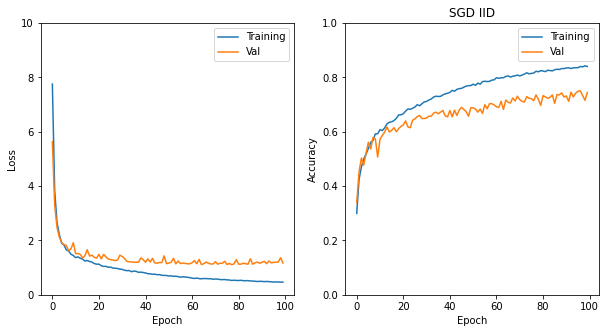

In [56]:
# We're first going to run SGD on some IID data
# Note: you might have to change the file path if you're using Colab to whereever you've stored the data

(trainX, trainY), (valX, valY) = read_and_process_data('synthetic_train_iid.json', 'synthetic_test_iid.json', combine_client_data=True)
training_loss, training_acc, val_loss, val_acc = sgd(trainX, trainY, valX, valY)
plot('SGD IID', training_loss, training_acc, val_loss, val_acc)

epoch: 0        training_loss: 2.602    training_acc: 0.5834   val_loss: 5.306    val_acc: 0.2248   time: 0.4331686496734619
epoch: 1        training_loss: 1.435    training_acc: 0.5645   val_loss: 4.461    val_acc: 0.2509   time: 0.4192204475402832
epoch: 2        training_loss: 1.203    training_acc: 0.6265   val_loss: 2.125    val_acc: 0.4969   time: 0.8838486671447754
epoch: 3        training_loss: 0.8994   training_acc: 0.7075   val_loss: 1.507    val_acc: 0.5702   time: 0.8097007274627686
epoch: 4        training_loss: 0.7474   training_acc: 0.7548   val_loss: 1.429    val_acc: 0.5739   time: 0.5141165256500244
epoch: 5        training_loss: 0.7573   training_acc: 0.7424   val_loss: 1.338    val_acc: 0.5963   time: 0.8579142093658447
epoch: 6        training_loss: 0.6879   training_acc: 0.776    val_loss: 1.295    val_acc: 0.6012   time: 0.5267465114593506
epoch: 7        training_loss: 0.6861   training_acc: 0.7707   val_loss: 1.269    val_acc: 0.6199   time: 0.8450155258178711


<Figure size 432x288 with 0 Axes>

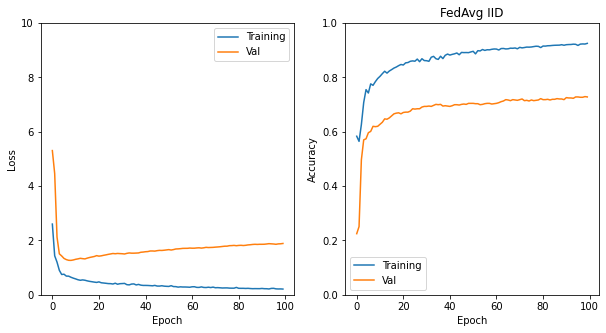

In [74]:
# And now we're going to compare the results with FedAvg
# Note: you might have to change the file path if you're using Colab to whereever you've stored the data

(trainX, trainY), (valX, valY) = read_and_process_data('synthetic_train_iid.json', 'synthetic_test_iid.json', combine_client_data=False)
training_loss, training_acc, val_loss, val_acc = fedavg(trainX, trainY, valX, valY)
plot('FedAvg IID', training_loss, training_acc, val_loss, val_acc)

epoch: 0        training_loss: 6.313    training_acc: 0.4201   val_loss: 11.73    val_acc: 0.09594  time: 0.06906485557556152
epoch: 1        training_loss: 5.945    training_acc: 0.2523   val_loss: 4.257    val_acc: 0.2823   time: 0.10953855514526367
epoch: 2        training_loss: 3.993    training_acc: 0.2986   val_loss: 2.914    val_acc: 0.3275   time: 0.1327359676361084
epoch: 3        training_loss: 3.198    training_acc: 0.3442   val_loss: 3.632    val_acc: 0.345    time: 0.10548210144042969
epoch: 4        training_loss: 3.094    training_acc: 0.3554   val_loss: 2.923    val_acc: 0.3266   time: 0.13016963005065918
epoch: 5        training_loss: 3.038    training_acc: 0.3589   val_loss: 2.597    val_acc: 0.3432   time: 0.11507534980773926
epoch: 6        training_loss: 2.942    training_acc: 0.3694   val_loss: 2.345    val_acc: 0.3976   time: 0.1272122859954834
epoch: 7        training_loss: 2.793    training_acc: 0.3775   val_loss: 2.539    val_acc: 0.4151   time: 0.118768215179

<Figure size 432x288 with 0 Axes>

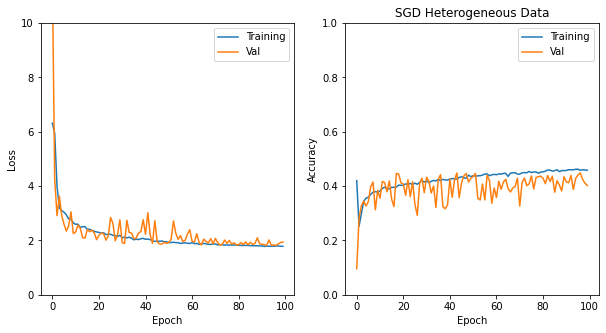

In [47]:
# Let's take a look at some heterogeneous data with SGD
# Note: you might have to change the file path if you're using Colab to whereever you've stored the data

(trainX, trainY), (valX, valY) = read_and_process_data('synthetic_train_heterogeneous.json', 'synthetic_test_heterogeneous.json', combine_client_data=True)
training_loss, training_acc, val_loss, val_acc = sgd(trainX, trainY, valX, valY)
plot('SGD Heterogeneous Data', training_loss, training_acc, val_loss, val_acc)

epoch: 0        training_loss: 1.122    training_acc: 0.7297   val_loss: 6.147    val_acc: 0.3681   time: 1.1909031867980957
epoch: 1        training_loss: 0.964    training_acc: 0.7158   val_loss: 5.548    val_acc: 0.4585   time: 1.1689643859863281
epoch: 2        training_loss: 0.8178   training_acc: 0.7294   val_loss: 5.496    val_acc: 0.4576   time: 1.1665945053100586
epoch: 3        training_loss: 0.8432   training_acc: 0.7256   val_loss: 5.622    val_acc: 0.4382   time: 1.0963373184204102
epoch: 4        training_loss: 1.147    training_acc: 0.636    val_loss: 5.11     val_acc: 0.4373   time: 0.45853519439697266
epoch: 5        training_loss: 0.8618   training_acc: 0.7105   val_loss: 5.086    val_acc: 0.4493   time: 1.1218080520629883
epoch: 6        training_loss: 0.8113   training_acc: 0.7247   val_loss: 4.907    val_acc: 0.4511   time: 1.1887116432189941
epoch: 7        training_loss: 0.7525   training_acc: 0.7366   val_loss: 4.627    val_acc: 0.4668   time: 1.2196319103240967

<Figure size 432x288 with 0 Axes>

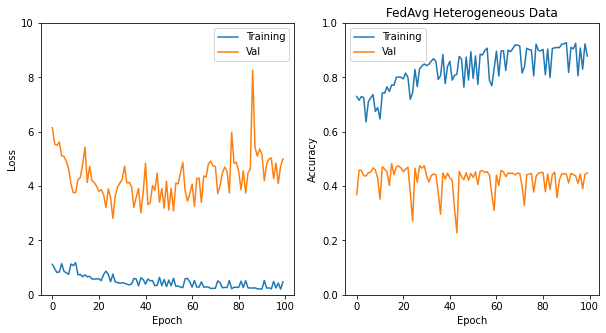

In [76]:
# And finally, let's see how FedAvg performs on the heterogeneous data
# Note: you might have to change the file path if you're using Colab to whereever you've stored the data

(trainX, trainY), (valX, valY) = read_and_process_data('synthetic_train_heterogeneous.json', 'synthetic_test_heterogeneous.json', combine_client_data=False)
training_loss, training_acc, val_loss, val_acc = fedavg(trainX, trainY, valX, valY)
plot('FedAvg Heterogeneous Data', training_loss, training_acc, val_loss, val_acc)